# Packages

In [3]:
# packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import json
from math import log, e
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.font_manager as font_manager
from IPython.core.display import display, HTML
from sklearn import preprocessing
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import operator
import spacy
import en_core_web_sm
import nltk
import wordcloud

min_max_scaler = preprocessing.MinMaxScaler()
display(HTML("<style>.container { width:90% !important; }</style>"))
%config IPCompleter.greedy= False
%config Completer.use_jedi = False
%matplotlib inline

In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

In [4]:
nlp = en_core_web_sm.load()

# Functions

In [5]:
# functions
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))
    return normalized

def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

# Loading dataset

In [150]:
df = pd.read_csv('../text_analysis_for_B_X/data/Temporal judgments – past self environment – control_text analysis.csv')

In [151]:
df.rename(columns={'self':'text'}, inplace=True)

In [152]:
df['text'].fillna(df['environment'], inplace=True)
df['text'].fillna(df['control'], inplace=True)

In [153]:
df.drop(columns=['environment', 'control'], inplace=True)

# Tokenize and normalize texts

In [154]:
df['tokenized_text'] = df['text'].apply(word_tokenize)
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))
df['normalized_tokens_count'] = df['normalized_tokens'].apply(lambda x: len(x))

# POS (Part Of Speech) analysis

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. 

In [155]:
df['POS'] = [spacy_pos(t) for t in df['text']]

In [156]:
df['POS_Cond_Fr_Dist'] = df['POS'].apply(lambda x: nltk.ConditionalFreqDist((p,w) for w, p in x))

In [157]:
df['JJ_top'] = df['POS_Cond_Fr_Dist'].apply(lambda x: x['JJ'].most_common(1))
df['NN_top'] = df['POS_Cond_Fr_Dist'].apply(lambda x: x['NN'].most_common(1))
df['VB_top'] = df['POS_Cond_Fr_Dist'].apply(lambda x: x['VB'].most_common(1))
df['RB_top'] = df['POS_Cond_Fr_Dist'].apply(lambda x: x['RB'].most_common(1))

In [91]:
gb = pd.DataFrame(df.groupby('condition')['POS', 'POS_Cond_Fr_Dist'].sum()).reset_index()

/var/folders/21/fsq8w42j1m97vxcqzszkztsr0000gn/T/ipykernel_96646/1140322657.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gb = pd.DataFrame(df.groupby('condition')['POS', 'POS_Cond_Fr_Dist'].sum()).reset_index()


In [119]:
gb['POS'].apply(lambda x: [t[0] for t in x if t[1]=='JJ'])

0    [current, entire, reliable, able, electric, ne...
1    [young, first, exciting, fun, new, new, new, n...
2    [different, easy, many, carefree, reckless, va...
Name: POS, dtype: object

In [120]:
gb['JJ_all'] = gb['POS'].apply(lambda x: [t[0] for t in x if t[1]=='JJ'])
gb['NN_all'] = gb['POS'].apply(lambda x: [t[0] for t in x if t[1]=='NN'])
gb['VB_all'] = gb['POS'].apply(lambda x: [t[0] for t in x if t[1]=='VB'])
gb['RB_all'] = gb['POS'].apply(lambda x: [t[0] for t in x if t[1]=='RB'])

In [121]:
gb['JJ_top'] = gb['POS_Cond_Fr_Dist'].apply(lambda x: x['JJ'].most_common(10))
gb['NN_top'] = gb['POS_Cond_Fr_Dist'].apply(lambda x: x['NN'].most_common(10))
gb['VB_top'] = gb['POS_Cond_Fr_Dist'].apply(lambda x: x['VB'].most_common(10))
gb['RB_top'] = gb['POS_Cond_Fr_Dist'].apply(lambda x: x['RB'].most_common(10))

In [122]:
gb

condition                                                POS  \
0      control  [(about, RB), (10, CD), (years, NNS), (ago, RB...   
1  environment  [(10, CD), (years, NNS), (ago, RB), (,, ,), (i...   
2         self  [(i, PRP), (was, VBD), (a, DT), (different, JJ...   

                                    POS_Cond_Fr_Dist  \
0  {'RB': {'about': 14, 'ago': 167, 'just': 81, '...   
1  {'CD': {'10': 75, '20': 3, '3d': 1, '1.0': 1, ...   
2  {'PRP': {'i': 1718, 'them': 23, 'myself': 80, ...   

                                              JJ_all  \
0  [current, entire, reliable, able, electric, ne...   
1  [young, first, exciting, fun, new, new, new, n...   
2  [different, easy, many, carefree, reckless, va...   

                                              NN_all  \
0  [today, hometown, home, privacy, fence, backya...   
1  [apartment, spouse, everything, apartment, mid...   
2  [person, everything, teenager, lot, world, sta...   

                                              VB_all  \
0  [have, keep, purchase, get, transfer, do, help...   
1  [dodge, bother, go, drive, exercise, do, have,...   
2  [have, do, care, understand, need, be, perform...   

                                              RB_all  \
0  [about, ago, just, recently, back, also, also,...   
1  [ago, just, very, right, also, mentally, later...   
2  [ago, now, very, not, as, now, somewhat, ago, ...   

                                              JJ_top  \
0  [(new, 50), (high, 46), (first, 41), (old, 40)...   
1  [(new, 52), (high, 50), (old, 45), (same, 38),...   
2  [(old, 52), (good, 44), (different, 42), (new,...   

                                              NN_top  \
0  [(time, 222), (school, 114), (life, 94), (year...   
1  [(time, 226), (school, 125), (house, 85), (lot...   
2  [(time, 170), (life, 123), (school, 85), (lot,...   

                                              VB_top  \
0  [(have, 75), (be, 72), (get, 44), (go, 33), (d...   
1  [(have, 62), (go, 52), (be, 36), (get, 29), (d...   
2  [(be, 82), (have, 69), (go, 33), (do, 30), (ge...   

                                              RB_top  
0  [(ago, 167), (just, 81), (not, 81), (very, 80)...  
1  [(ago, 145), (n't, 97), (not, 90), (very, 73),...  
2  [(ago, 181), (very, 135), (not, 127), (n't, 10...

## wordcloud

### JJ

In [127]:
wc_control = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'control']['JJ_all'].sum()))

wc_environment = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'environment']['JJ_all'].sum()))

wc_self = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'self']['JJ_all'].sum()))

(-0.5, 1499.5, 499.5, -0.5)

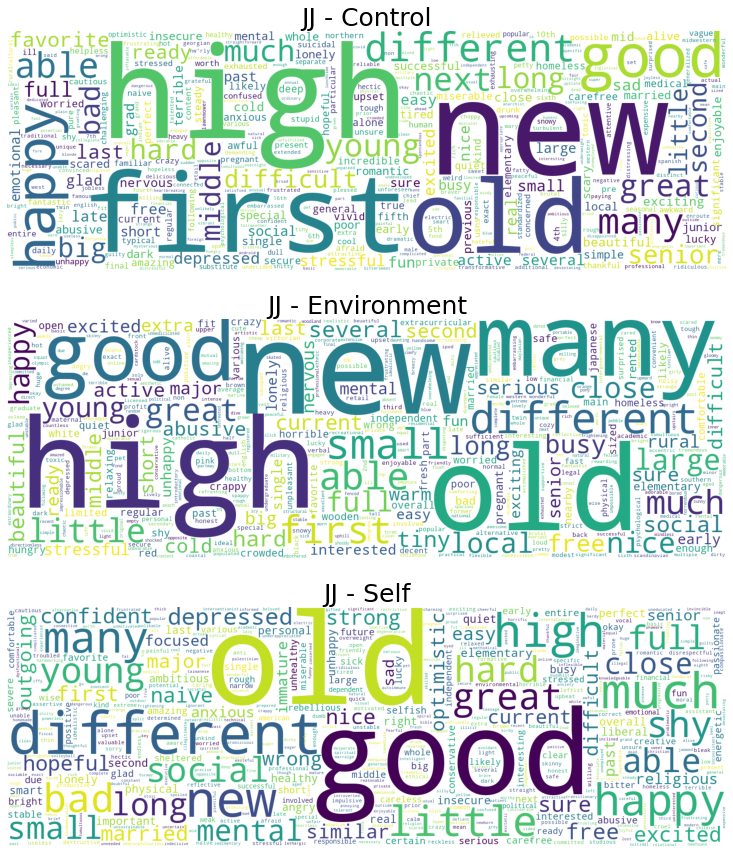

In [128]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(wc_control)
axs[0].set_title("JJ - Control", fontdict={'fontsize':25})
axs[0].axis("off")

axs[1].imshow(wc_environment)
axs[1].set_title("JJ - Environment", fontdict={'fontsize':25})
axs[1].axis("off")

axs[2].imshow(wc_self)
axs[2].set_title("JJ - Self", fontdict={'fontsize':25})
axs[2].axis("off")

### NN

In [129]:
wc_control = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'control']['NN_all'].sum()))

wc_environment = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'environment']['NN_all'].sum()))

wc_self = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'self']['NN_all'].sum()))

(-0.5, 1499.5, 499.5, -0.5)

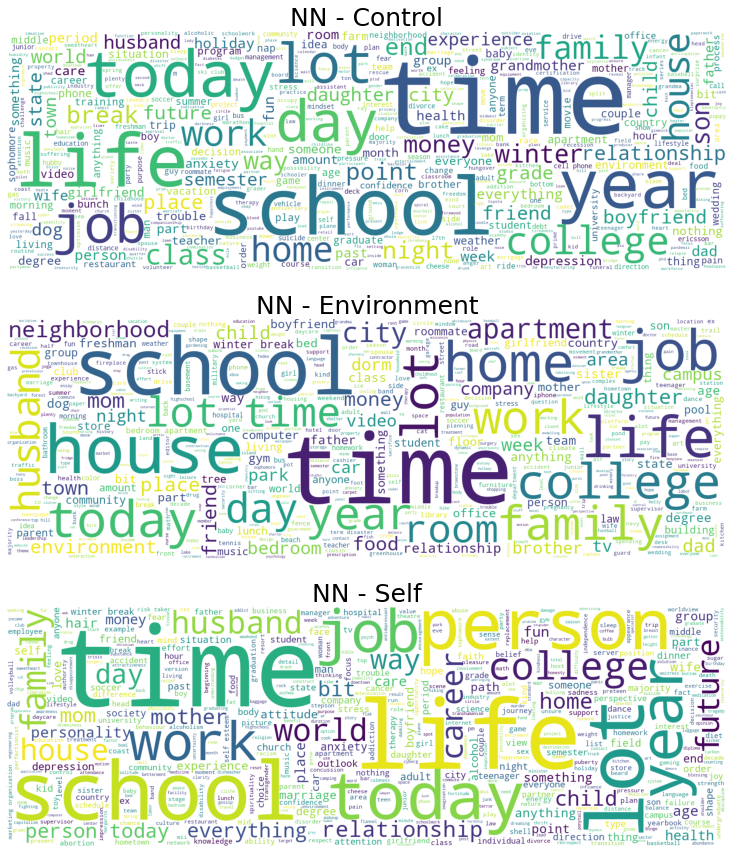

In [130]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(wc_control)
axs[0].set_title("NN - Control", fontdict={'fontsize':25})
axs[0].axis("off")

axs[1].imshow(wc_environment)
axs[1].set_title("NN - Environment", fontdict={'fontsize':25})
axs[1].axis("off")

axs[2].imshow(wc_self)
axs[2].set_title("NN - Self", fontdict={'fontsize':25})
axs[2].axis("off")

### VB

In [131]:
wc_control = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'control']['VB_all'].sum()))

wc_environment = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'environment']['VB_all'].sum()))

wc_self = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'self']['VB_all'].sum()))

(-0.5, 1499.5, 499.5, -0.5)

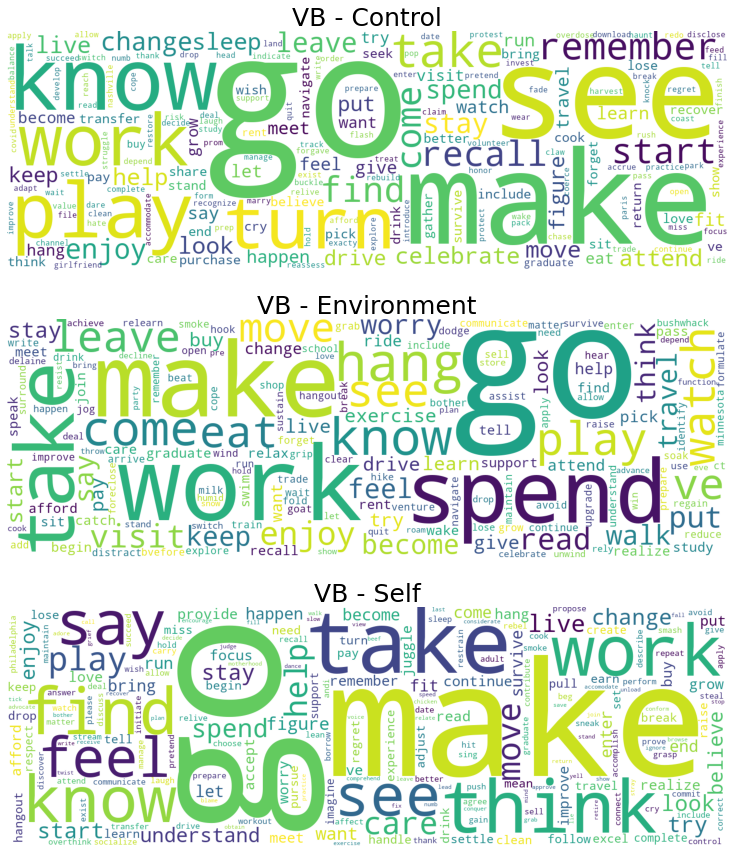

In [132]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(wc_control)
axs[0].set_title("VB - Control", fontdict={'fontsize':25})
axs[0].axis("off")

axs[1].imshow(wc_environment)
axs[1].set_title("VB - Environment", fontdict={'fontsize':25})
axs[1].axis("off")

axs[2].imshow(wc_self)
axs[2].set_title("VB - Self", fontdict={'fontsize':25})
axs[2].axis("off")

### RB

In [133]:
wc_control = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'control']['RB_all'].sum()))

wc_environment = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'environment']['RB_all'].sum()))

wc_self = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb[gb.condition == 'self']['RB_all'].sum()))

(-0.5, 1499.5, 499.5, -0.5)

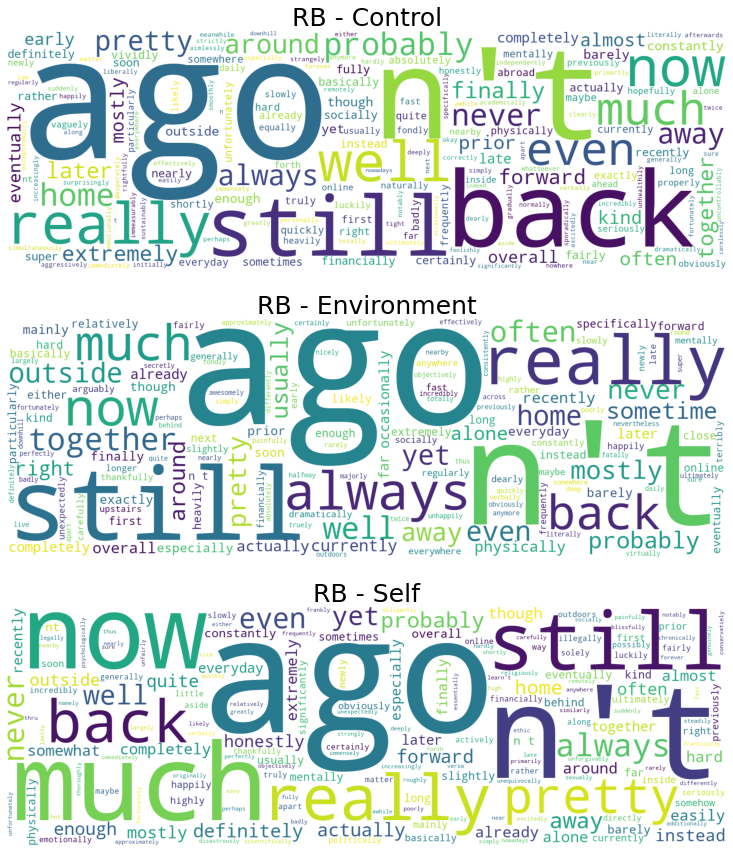

In [134]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(wc_control)
axs[0].set_title("RB - Control", fontdict={'fontsize':25})
axs[0].axis("off")

axs[1].imshow(wc_environment)
axs[1].set_title("RB - Environment", fontdict={'fontsize':25})
axs[1].axis("off")

axs[2].imshow(wc_self)
axs[2].set_title("RB - Self", fontdict={'fontsize':25})
axs[2].axis("off")

# all tokens in wordcloud 

In [64]:
gb2 = pd.DataFrame(df.groupby('condition')['normalized_tokens'].sum()).reset_index()

In [73]:
gb2

condition                                  normalized_tokens
0      control  [year, ago, today, recently, move, hometown, p...
1  environment  [year, ago, young, go, partie, friend, move, a...
2         self  [different, person, year, ago, easy, go, respo...

In [76]:
wc_control = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb2[gb2.condition == 'control']['normalized_tokens'].sum()))

wc_environment = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb2[gb2.condition == 'environment']['normalized_tokens'].sum()))

wc_self = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=1000, mode='RGBA', scale=.5).generate(
    ' '.join(gb2[gb2.condition == 'self']['normalized_tokens'].sum()))

(-0.5, 1499.5, 499.5, -0.5)

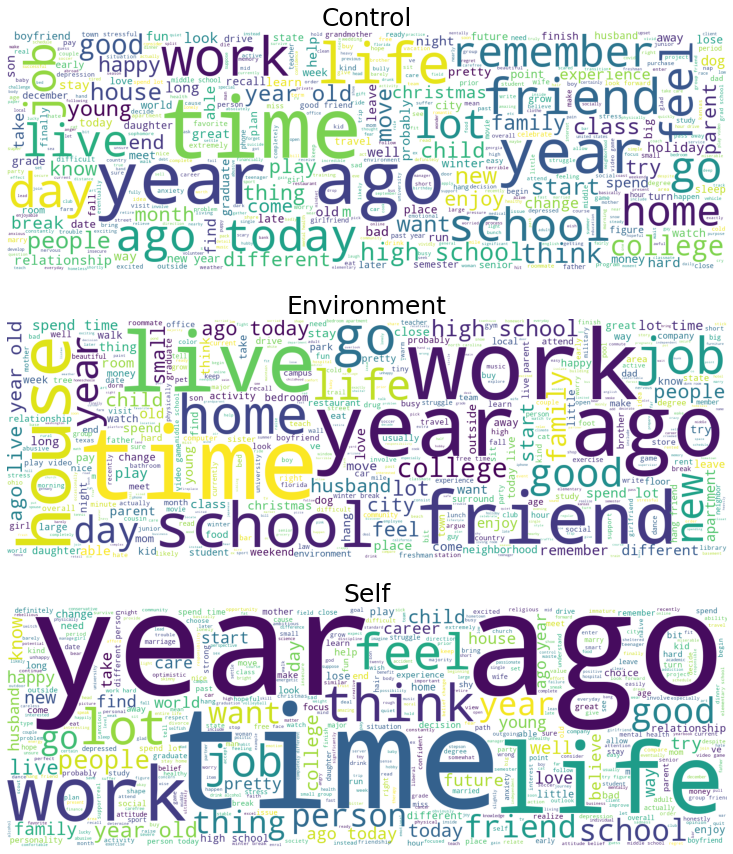

In [80]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(wc_control)
axs[0].set_title("Control", fontdict={'fontsize':25})
axs[0].axis("off")

axs[1].imshow(wc_environment)
axs[1].set_title("Environment", fontdict={'fontsize':25})
axs[1].axis("off")

axs[2].imshow(wc_self)
axs[2].set_title("Self", fontdict={'fontsize':25})
axs[2].axis("off")

---

# Sentiment analysis using VADER 

>- VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
>- Check out the original VADER paper: https://ojs.aaai.org/index.php/ICWSM/article/view/14550

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyser = SentimentIntensityAnalyzer()

In [137]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [160]:
df['VADER_dict'] = df['text'].apply(analyser.polarity_scores)

In [161]:
df = pd.concat([df.drop('VADER_dict', axis=1), df['VADER_dict'].apply(pd.Series)], axis=1)

In [185]:
df[:3]

workerId condition  \
0  A3MP9M2BVN9I53   control   
1  A17KN7NAP48L4B   control   
2   AVP43UTC8XRWY   control   

                                                text  \
0  About 10 years ago from today I would have jus...   
1  Ten years ago, I was in community college slow...   
2  Ten years ago today I was in my early 20s. I w...   

                                      tokenized_text  \
0  [About, 10, years, ago, from, today, I, would,...   
1  [Ten, years, ago, I, was, in, community, colle...   
2  [Ten, years, ago, today, I, was, in, my, early...   

                                   normalized_tokens  normalized_tokens_count  \
0  [year, ago, today, recently, move, hometown, p...                       27   
1  [year, ago, community, college, slowly, work, ...                       39   
2  [year, ago, today, early, 20, have, time, life...                       57   

                                                 POS  \
0  [(about, RB), (10, CD), (years, NNS), (ago, RB...   
1  [(ten, CD), (years, NNS), (ago, RB), (,, ,), (...   
2  [(ten, CD), (years, NNS), (ago, RB), (today, N...   

                                    POS_Cond_Fr_Dist          JJ_top  \
0  {'RB': {'about': 1, 'ago': 1, 'just': 1, 'rece...  [(current, 1)]   
1  {'CD': {'ten': 2, 'four': 1}, 'NNS': {'years':...  [(general, 1)]   
2  {'CD': {'ten': 1}, 'NNS': {'years': 1, '20s': ...     [(true, 2)]   

           NN_top       VB_top       RB_top    neg    neu    pos  compound  
0  [(vehicle, 2)]  [(have, 1)]  [(also, 2)]  0.000  0.961  0.039    0.4522  
1     [(time, 2)]   [(get, 1)]   [(ago, 2)]  0.085  0.891  0.024   -0.7837  
2    [(today, 2)]    [(do, 1)]   [(ago, 1)]  0.060  0.806  0.134    0.9109

## KDE plots with descriptive stats

### negativity 

mean       std
condition                      
control      0.064830  0.054280
environment  0.042252  0.041173
self         0.072244  0.061866

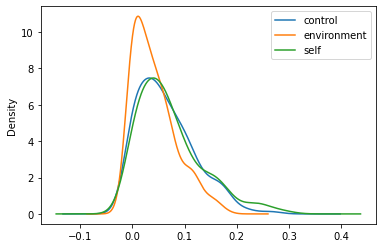

In [182]:
df.groupby('condition')['neg'].plot.kde(legend=True)
df.groupby('condition')['neg'].agg(['mean','std'])

### positivity

mean       std
condition                      
control      0.111158  0.066147
environment  0.092648  0.058858
self         0.120477  0.066530

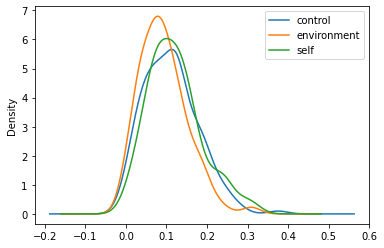

In [183]:
df.groupby('condition')['pos'].plot.kde(legend=True)
df.groupby('condition')['pos'].agg(['mean','std'])

### neutrality

mean       std
condition                      
control      0.824082  0.076168
environment  0.865119  0.064423
self         0.807320  0.076799

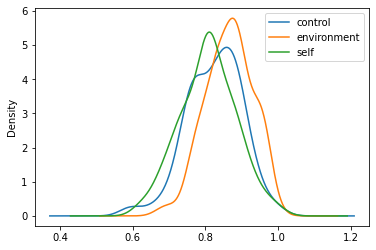

In [184]:
df.groupby('condition')['neu'].plot.kde(legend=True)
df.groupby('condition')['neu'].agg(['mean','std'])